# Testing Machine Unlearning against Gaussian data poisoning

This is a sample implementation of gaussian data poisoning as described by the AI Security paper [Machine Unlearning Fails to Remove Data Poisoning Attacks
](https://arxiv.org/abs/2406.17216).

## Imports

In [1]:
from __future__ import annotations

from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import torch
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules.loss import _Loss, CrossEntropyLoss
from torch.optim import Optimizer, SGD, AdamW
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as T
from torchmetrics.classification import MulticlassAccuracy
import torchinfo

In [2]:
from image_classification.utils import seed_all_generators, use_tqdm
from image_classification.accel import BEST_DEVICE, optimize_model
from image_classification.datasets import EagerDataset, cifar10_train_test
from image_classification.models import ResNet, MobileNetV3, SqueezeNet1_1, EfficientNet, SmallCNN, BigCNN
from image_classification.nn import (
    train_loop,
    train_val_loop,
    test_epoch,
)
from image_classification.gaussian_poisoning import (
    GaussianPoisoningDataset,
    gaussian_unlearning_score,
)
from image_classification.unlearning import (
    gradient_descent,
    gradient_ascent,
    neg_grad_plus,
    oracle_unlearning,
    unlearning_last_layers,
    scrub,
    NoisySGD,
)

# For deterministic results
seed_all_generators(0x2023_2024)

# NOTE: Don't forget to clear all outputs in vscode before running.
# 
# WARNING (Windows): consider setting ascii=True and installing vscode-tqdm
# if notebook display issues persist: https://pypi.org/project/vscode-tqdm/
# Alternatively, set enable=False (but there won't be interactive output).
use_tqdm(enable=False, ascii=False)

Using cuda device


## Datasets

We work on the CIFAR-10 dataset.

### Get the dataset

In [3]:
training_data, test_data = cifar10_train_test(root='data')
N_test = len(test_data)
N_val = len(training_data) // 10
N = len(training_data) - N_val
# This works since training data is already shuffled
training_data, val_data = training_data.split([N, N_val])

batch_size = 50
N, N_val, N_test

(45000, 5000, 10000)

In [4]:
X = training_data.data
y = training_data.targets

In [5]:
def target_name(y: int) -> str:
    return training_data.classes[y]

### Poison the training samples

The attacker poisons a fraction $\varepsilon$ of the features with noise $(\xi_z)_{z \in S_\mathrm{poison}}$ and stores the noise for future usage.

In [6]:
poison_budget = 0.015
noise_std = np.sqrt(0.32) * X.std().item()

corrupted_dataset = GaussianPoisoningDataset(
    training_data,
    poison_budget,
    noise_std,
)

S_poison: Tensor[bool] = corrupted_dataset.poison_support
N_poison = corrupted_dataset.num_poisons()
N_clean = N - N_poison

y_base: Tensor = y[S_poison.cpu()]
X_base: Tensor = corrupted_dataset.clean_dataset.data[S_poison]
X_poison: Tensor = corrupted_dataset.data[S_poison]
poisoning_noise: Tensor = corrupted_dataset.noise[S_poison]

# Another independent standard noise used as a baseline for unlearning evaluation
# (not used to corrupt the dataset)
dummy_noise = noise_std * torch.randn_like(poisoning_noise)

print(f'Clean data standard deviation: {X_base.std().item():.2g}')
print(f'Noise standard deviation: {poisoning_noise.std().item():.2g}')
print('Noise data for poisoning:', poisoning_noise.shape)

Clean data standard deviation: 1
Noise standard deviation: 0.57
Noise data for poisoning: torch.Size([688, 3, 32, 32])


### Inspecting the poisoned data

In [7]:
def display_input_image(input: Tensor, label: Tensor, title='', cmap=None):
    """
    Displays an an input image to a neural network.

    `input`: a 3D tensor
    `cmap`: grayscale by default.
    """
    image = input.numpy(force=True)
    class_ = target_name(label.item())

    # Unnormalize CIFAR10 image to [0, 1]
    mean = np.array([0.4914, 0.4822, 0.4465]).reshape(3, 1, 1)
    std = np.array([0.247, 0.243, 0.261]).reshape(3, 1, 1)
    image = (std * image) + mean

    image = np.transpose(image, (1, 2, 0))

    fig, ax = plt.subplots()
    ax.imshow(image, cmap=cmap, interpolation='nearest')
    plt.title(class_)
    fig.suptitle(title, fontsize=14)
    fig.tight_layout()

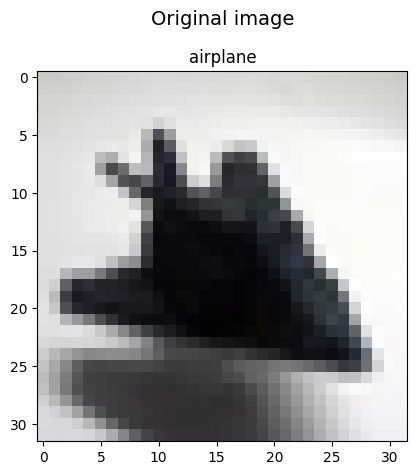

In [8]:
display_input_image(X_base[0], y_base[0], title='Original image')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3830021329879761..1.465007860660553].


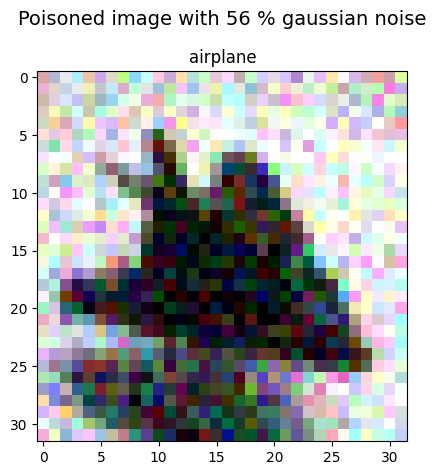

In [9]:
display_input_image(
    X_poison[0], y_base[0],
    title=f'Poisoned image with {int(100 * noise_std)} % gaussian noise'
)

Despite the amplitude of added noise, the image is still recognizable.

### Threat model

The defender unknowingly collects corrupted data, which contains a small fraction of poisons.

From now on, we consider the following scenario :
1. The defender trains the model on the corrupted dataset.
2. The defender realizes afterwards they have been poisoned, and is able to determine which part of the dataset has been corrupted.
3. The defender runs the unlearning algorithm on the poisoned dataset.

We may also study a stronger relaxation of step 2 with the hypothesis that the defender is able to determine the exact values of the poisons. This unrealistic scenario may be used to prove that Machine Unlearning is necessarily vulnerable to data poisoning. Indeed, if Machine Unlearning fails with such strong assumptions, we may conclude the effect of data poisoning on the model parameters is simply irreversible.

## The model architecture

We use a ResNet-18 classifier on CIFAR-10.

In [10]:
model = ResNet(num_layers=18).to(BEST_DEVICE)

print(model)

ResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [11]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                        Param #
ResNet                                        --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            9,408
│    └─BatchNorm2d: 2-2                       128
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   73,984
│    │    └─BasicBlock: 3-2                   73,984
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-3                   230,144
│    │    └─BasicBlock: 3-4                   295,424
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-5                   919,040
│    │    └─BasicBlock: 3-6                   1,180,672
│    └─Sequential: 2-8                        --
│    │    └─BasicBlock: 3-7                   3,673,088
│    │    └─BasicBlock: 3-8                   4,720,640
│    └─AdaptiveA

## Train the model

### Clean sets, corrupted sets and poisons

In [12]:
# The retain set
clean_subset = corrupted_dataset.clean_subset()
clean_loader = DataLoader(clean_subset, batch_size, drop_last=True)

# The forget set
poisoned_subset = corrupted_dataset.poisoned_subset()
poisoned_loader = DataLoader(poisoned_subset, batch_size, drop_last=True)

# The forget set before poisoning
base_subset = corrupted_dataset.clean_subset_before_poisoning()
base_loader = DataLoader(base_subset, batch_size, drop_last=True)

# The clean validation set
val_loader = DataLoader(val_data, batch_size, drop_last=True)

# The clean test set
test_loader = DataLoader(test_data, batch_size, drop_last=True)

# The corrupted set (clean and poisons)
corrupted_loader = DataLoader(corrupted_dataset, batch_size, drop_last=True)

### Hyperparameters

In [13]:
lr = 1e-3
weight_decay = 5e-4

epochs = 8

loss_func = CrossEntropyLoss()

metric = MulticlassAccuracy(num_classes=10)

In [14]:
def make_optimizer(model: nn.Module, lr=lr, weight_decay=weight_decay) -> Optimizer:
    return AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

### Clean model

In [15]:
clean_model = deepcopy(model)
opt = make_optimizer(clean_model)
train_val_loop(clean_model, clean_loader, val_loader, loss_func, opt, epochs=epochs, metric=metric)
test_epoch(clean_model, test_loader, loss_func, keep_pbars=True, metric=metric)

/home/lvt/.local/share/virtualenvs/ml-TQx6uCZG/lib/python3.13/site-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


100%|█████████▉| 44300/44312 [00:00<?, ?it/s]
MulticlassAccuracy: 0.561
100%|██████████| 5000/5000 [00:00<?, ?it/s]
MulticlassAccuracy: 0.487
100%|█████████▉| 44300/44312 [00:00<?, ?it/s]
MulticlassAccuracy: 0.67
100%|█████████▉| 44300/44312 [00:00<?, ?it/s]
MulticlassAccuracy: 0.681
100%|██████████| 5000/5000 [00:00<?, ?it/s]
MulticlassAccuracy: 0.594
100%|█████████▉| 44300/44312 [00:00<?, ?it/s]
MulticlassAccuracy: 0.733
100%|█████████▉| 44300/44312 [00:00<?, ?it/s]
MulticlassAccuracy: 0.832
100%|██████████| 5000/5000 [00:00<?, ?it/s]
MulticlassAccuracy: 0.546
Validation loss stopped improving, exiting train loop.
100%|██████████| 10000/10000 [00:00<?, ?it/s]
MulticlassAccuracy: 0.627


{'MulticlassAccuracy': 0.6266270279884338, 'avg_loss': 0.9741002428531647}

### Corrupted model

In [16]:
corrupted_model = deepcopy(model)
opt = make_optimizer(corrupted_model)
train_val_loop(corrupted_model, corrupted_loader, val_loader, loss_func, opt, epochs=epochs, metric=metric)

100%|██████████| 45000/45000 [00:00<?, ?it/s]
MulticlassAccuracy: 0.475
100%|██████████| 5000/5000 [00:00<?, ?it/s]
MulticlassAccuracy: 0.496
100%|██████████| 45000/45000 [00:00<?, ?it/s]
MulticlassAccuracy: 0.655
100%|██████████| 45000/45000 [00:00<?, ?it/s]
MulticlassAccuracy: 0.71
100%|██████████| 5000/5000 [00:00<?, ?it/s]
MulticlassAccuracy: 0.548
100%|██████████| 45000/45000 [00:00<?, ?it/s]
MulticlassAccuracy: 0.75
100%|██████████| 45000/45000 [00:00<?, ?it/s]
MulticlassAccuracy: 0.804
100%|██████████| 5000/5000 [00:00<?, ?it/s]
MulticlassAccuracy: 0.633
Validation loss stopped improving, exiting train loop.


In [ ]:
#inspect_model(corrupted_model)

# FIXME: loss shouldn't be strictly equal to zero
print('\n\nOn the clean subset:')
test_epoch(corrupted_model, clean_loader, loss_func, keep_pbars=True, metric=metric)

print('\n\nOn the (clean) test set:')
test_epoch(corrupted_model, test_loader, loss_func, keep_pbars=True, metric=metric)

print('\n\nOn the original version of the poisoned subset before poisoning:')
test_epoch(corrupted_model, base_loader, loss_func, keep_pbars=True, metric=metric)

print('\n\nOn the poisoned subset:')
test_epoch(corrupted_model, poisoned_loader, loss_func, keep_pbars=True, metric=metric);



On the clean subset:
100%|█████████▉| 44300/44312 [00:00<?, ?it/s]
MulticlassAccuracy: 0.854


On the (clean) test set:
100%|██████████| 10000/10000 [00:00<?, ?it/s]
MulticlassAccuracy: 0.696


On the original version of the poisoned subset before poisoning:
 94%|█████████▍| 650/688 [00:00<?, ?it/s]
MulticlassAccuracy: 0.755


On the poisoned subset:
 94%|█████████▍| 650/688 [00:00<?, ?it/s]
MulticlassAccuracy: 0.794


{'MulticlassAccuracy': 0.7941667437553406, 'avg_loss': 0.7663188874721527}

## Machine Unlearning

### Gradient Descent (GD)

> GD continues to train the model $\theta_{\mathrm{initial}}$ on the
remaining dataset $S_{\mathrm{train}} \setminus U$ by using gradient descent. In particular, we obtain $\theta_{\mathrm{updated}}$ via
> 
> $\theta_{t+1} \gets \theta_t − \eta g_t (\theta_t)$ with $\theta_1 = \theta_{\mathrm{initial}}$
> 
> where $\eta$ denotes the step size and $g_t$ denotes a (mini-batch) gradient computed for the the training
loss $\widehat{\mathbb{E}}_{(x,y) \in S_{\mathrm{train}} \setminus U} \left[l((x, y), \theta)\right]$ defined using the remaining dataset $S_{\mathrm{train}} \setminus U$, where $l$ is a loss function, e.g., cross-entropy loss, hinge loss, etc.

### Gradient Ascent (GA)

> GA is an unlearning algorithm which attempts to remove the influence of the forget set $U$ from the trained model by simply reversing the gradient updates that contain information about $U$. In particular, we update via
> 
> $\theta_{t+1} \gets \theta_t + \eta g_t (\theta_t)$ with $\theta_1 = \theta_{\mathrm{initial}}$
> 
> where $g_t$ denotes a (mini-batch) gradient computed for the the training loss $\widehat{\mathbb{E}}_{(x,y) \in U} \left[l((x, y), \theta)\right]$ on the deletion
set.

## Evaluate the effect of Gaussian data poisoning

We follow the *Algorithm 3* in the original paper of Pawelczyk et al.

In [18]:
# NOTE: the computed standard deviation might not be 1 due to gradient vanishing
def evaluate_unlearning(
        model: nn.Module,
        base_data: Dataset,
        noise: Dataset,
        noise_std: float,
        loss_fn: _Loss,
        xi_name=r'$\xi$', g_name='g', method='',
    ):
    I_poison = gaussian_unlearning_score(
        model,
        base_data,
        noise,
        noise_std,
        loss_fn,
    )

    mean = I_poison.mean()
    std = I_poison.std()

    mean_std_theory = 1. / np.sqrt(float(len(noise)))

    plt.hist(I_poison, density=True)

    iz = np.linspace(I_poison.min(), I_poison.max())
    distr = stats.norm(mean, std)
    plt.plot(iz, distr.pdf(iz), label=fr'Gaussian fit: $\mathcal{{N}}({mean:.3}, {std**2:.3})$')
    
    distr = stats.norm(0.0, 1.0)
    plt.plot(iz, distr.pdf(iz), label=fr'Theory: $\mathcal{{N}}(0 \pm {mean_std_theory:.3g}, 1)$')

    plt.xlabel(fr'$\mathcal{{I}}_{{\mathrm{{poison}}}} = \frac{{\langle \xi, {g_name} \rangle}}{{\epsilon ||{g_name}||_2}}$')
    plt.title(fr'Normalized dot product distribution between input gradients ${g_name}$ and {xi_name}')
    if method:
        plt.suptitle(method)
    plt.legend()
    plt.show()

In [19]:
from image_classification.gaussian_poisoning import gaussian_unlearning_score

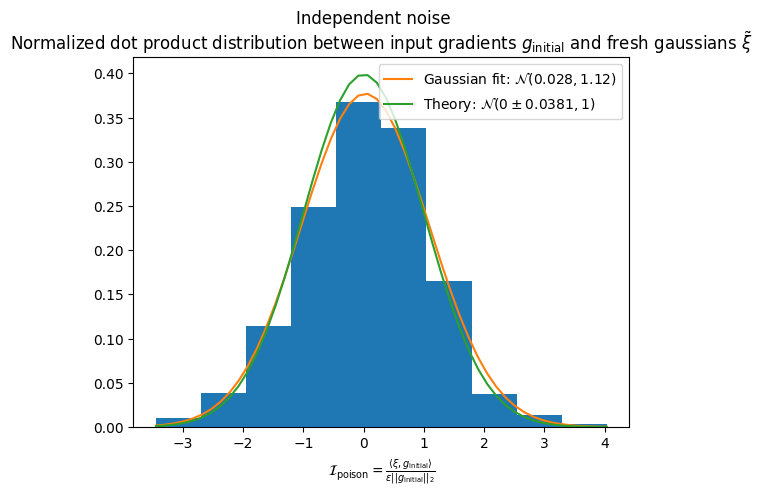

In [20]:
loss_func_no_reduction = CrossEntropyLoss(reduction='none')

evaluate_unlearning(
    corrupted_model, base_subset, dummy_noise, noise_std, loss_func_no_reduction,
    xi_name=r'fresh gaussians $\tilde{\xi}$', g_name=r'g_{\mathrm{initial}}', method='Independent noise'
)

When testing against independent noise, the result should be equivalent to perfect unlearning.

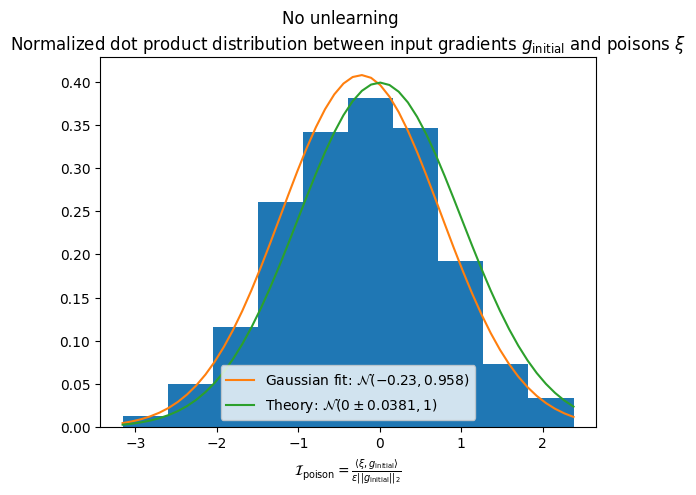

In [21]:
evaluate_unlearning(
    corrupted_model, base_subset, poisoning_noise, noise_std, loss_func_no_reduction,
    xi_name=r'poisons $\xi$', g_name=r'g_{\mathrm{initial}}', method='No unlearning'
)

For fresh Gaussians, the distribution should be centered around $0$.

Due to data poisoning, the model gradients are influenced by $\xi$ so the distribution is shifted.

FIXME: actually, there is very little correlation because the model seems to have minimized the loss over the clean samples rather than the poisoned samples, which is why the loss gradient is not correlated with the noise.

### Evaluate unlearning algorithms

We plot the previous distribution again, after running the unlearning algorithm.
If the distribution is still shifted, that means the model did not perfectly unlearn the poisons.

In [22]:
def display_post_unlearning_results(model: nn.Module, algo_name: str):
    print('\n\nTest on clean samples:')
    test_epoch(model, test_loader, loss_func, keep_pbars=True, metric=metric)
    print('\n\nTest on poisoned samples:')
    test_epoch(model, poisoned_loader, loss_func, keep_pbars=True, metric=metric)
    print('\n\n')
    evaluate_unlearning(
        model, base_subset, poisoning_noise, noise_std, loss_func_no_reduction,
        xi_name=r'Gaussian poisons $\xi$',
        g_name=r'g_{\mathrm{updated}}',
        method=algo_name,
    )
    # TODO: plot curve GUS / accuracy

In [23]:
def make_sgd(model: nn.Module, lr=lr, momentum=0.9, weight_decay=5e-4) -> Optimizer:
    return SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

### Gradient descent

100%|█████████▉| 44300/44312 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:00<?, ?it/s]

100%|█████████▉| 44300/44312 [00:00<?, ?it/s]

100%|█████████▉| 44300/44312 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:00<?, ?it/s]

100%|█████████▉| 44300/44312 [00:00<?, ?it/s]



Test on clean samples:
100%|██████████| 10000/10000 [00:00<?, ?it/s]
MulticlassAccuracy: 0.778


Test on poisoned samples:
 94%|█████████▍| 650/688 [00:00<?, ?it/s]
MulticlassAccuracy: 0.9





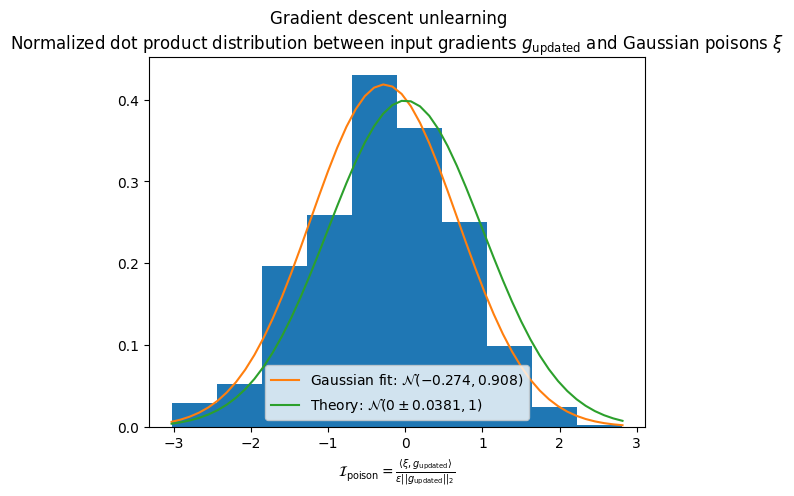

In [24]:
unlearn_epochs = 4
unlearner = deepcopy(corrupted_model)
opt_gd = make_sgd(unlearner, lr=1e-3)
gradient_descent(unlearner, clean_loader, val_loader, loss_func, opt_gd, epochs=unlearn_epochs)
display_post_unlearning_results(unlearner, algo_name='Gradient descent unlearning')

### Noisy gradient descent

100%|█████████▉| 44300/44312 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:00<?, ?it/s]

100%|█████████▉| 44300/44312 [00:00<?, ?it/s]

100%|█████████▉| 44300/44312 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:00<?, ?it/s]

100%|█████████▉| 44300/44312 [00:00<?, ?it/s]



Test on clean samples:
100%|██████████| 10000/10000 [00:00<?, ?it/s]
MulticlassAccuracy: 0.718


Test on poisoned samples:
 94%|█████████▍| 650/688 [00:00<?, ?it/s]
MulticlassAccuracy: 0.815





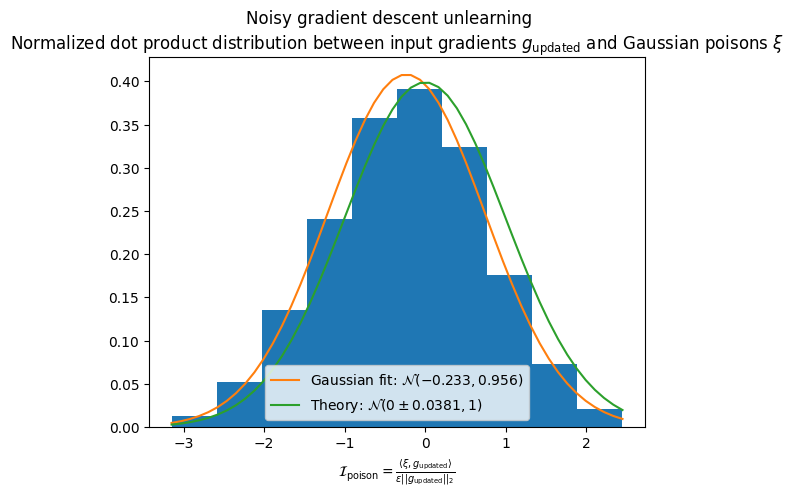

In [25]:
unlearn_epochs = 4
unlearner = deepcopy(corrupted_model)
opt_ngd = NoisySGD(unlearner.parameters(), noise_scale=np.sqrt(1e-6), lr=1e-3, momentum=0.9, weight_decay=5e-4)
gradient_descent(unlearner, clean_loader, val_loader, loss_func, opt_gd, epochs=unlearn_epochs)
display_post_unlearning_results(unlearner, algo_name='Noisy gradient descent unlearning')

### Gradient ascent

100%|█████████▉| 44300/44312 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:00<?, ?it/s]

100%|█████████▉| 44300/44312 [00:00<?, ?it/s]



Test on clean samples:
100%|██████████| 10000/10000 [00:00<?, ?it/s]
MulticlassAccuracy: 0.658


Test on poisoned samples:
 94%|█████████▍| 650/688 [00:00<?, ?it/s]
MulticlassAccuracy: 0.501





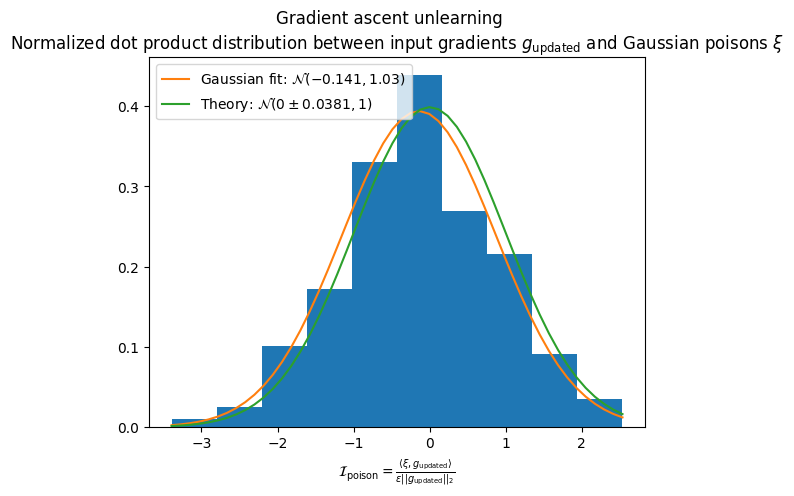

In [26]:
unlearn_epochs = 2
unlearner = deepcopy(corrupted_model)
opt_ga = make_sgd(unlearner, lr=1e-5)
gradient_ascent(unlearner, clean_loader, val_loader, loss_func, opt_ga, epochs=unlearn_epochs)
display_post_unlearning_results(unlearner, algo_name='Gradient ascent unlearning')

Gradient ascent induces a significant drop on the model accuracy . This is unavoidable since the algorithm does not control the model's performance on the retain set, which creates a tradeoff between unlearning and accuracy.

### NegGrad+

 94%|█████████▍| 650/688 [00:00<?, ?it/s]


Test on clean samples:
100%|██████████| 10000/10000 [00:00<?, ?it/s]
MulticlassAccuracy: 0.764


Test on poisoned samples:
 94%|█████████▍| 650/688 [00:00<?, ?it/s]
MulticlassAccuracy: 0.86





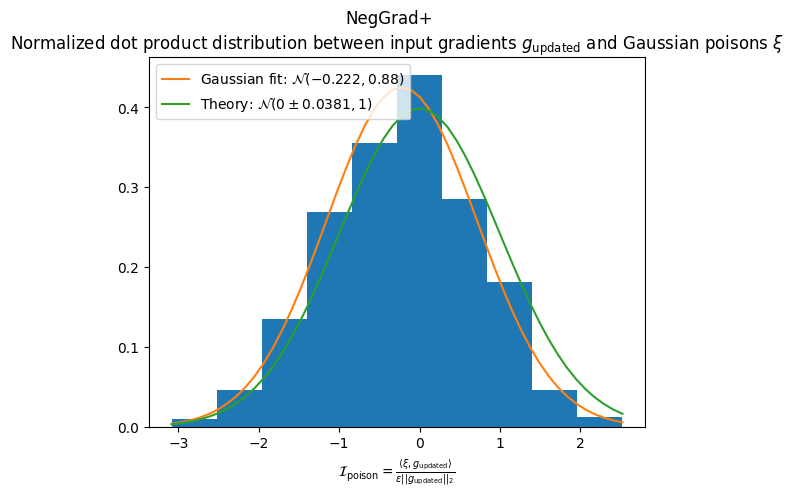

In [27]:
unlearn_epochs = 4
unlearner = deepcopy(corrupted_model)
opt_ngp = make_sgd(unlearner, lr=1e-3)
for _ in range(unlearn_epochs):
    neg_grad_plus(unlearner, clean_loader, poisoned_loader, loss_func, opt_ngp, beta=0.995)
display_post_unlearning_results(unlearner, algo_name='NegGrad+')

### Oracle unlearning (ours)

 94%|█████████▍| 650/688 [00:00<?, ?it/s]


Test on clean samples:
100%|██████████| 10000/10000 [00:00<?, ?it/s]
MulticlassAccuracy: 0.778


Test on poisoned samples:
 94%|█████████▍| 650/688 [00:00<?, ?it/s]
MulticlassAccuracy: 0.86





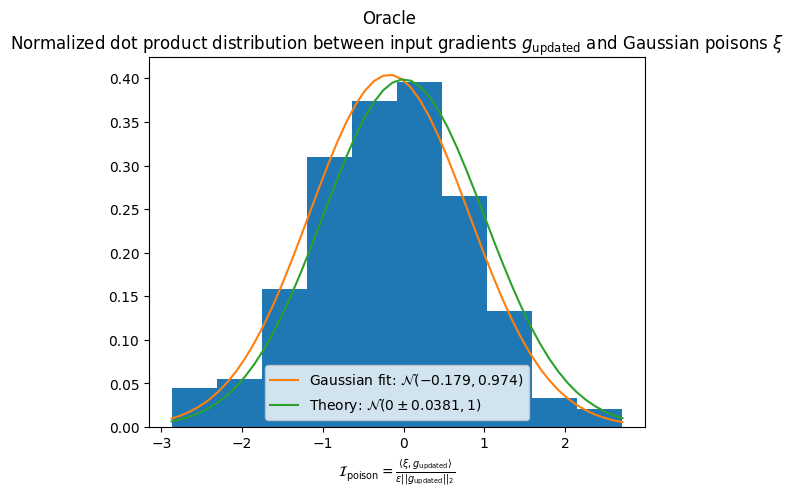

In [28]:
unlearn_epochs = 2
unlearner = deepcopy(corrupted_model)
# TODO:
# Future work: how to set learning rate according to GUS? Is GUS a relevant metric?
opt_oracle = make_optimizer(unlearner, lr=0.1 * lr)
for _ in range(unlearn_epochs):
    oracle_unlearning(unlearner, base_loader, poisoned_loader, loss_func, opt_oracle)
display_post_unlearning_results(unlearner, algo_name='Oracle')

### CFk

100%|█████████▉| 44300/44312 [00:00<?, ?it/s]

100%|█████████▉| 44300/44312 [00:00<?, ?it/s]

100%|█████████▉| 44300/44312 [00:00<?, ?it/s]

100%|█████████▉| 44300/44312 [00:00<?, ?it/s]



Test on clean samples:
100%|██████████| 10000/10000 [00:00<?, ?it/s]
MulticlassAccuracy: 0.628


Test on poisoned samples:
 94%|█████████▍| 650/688 [00:00<?, ?it/s]
MulticlassAccuracy: 0.63





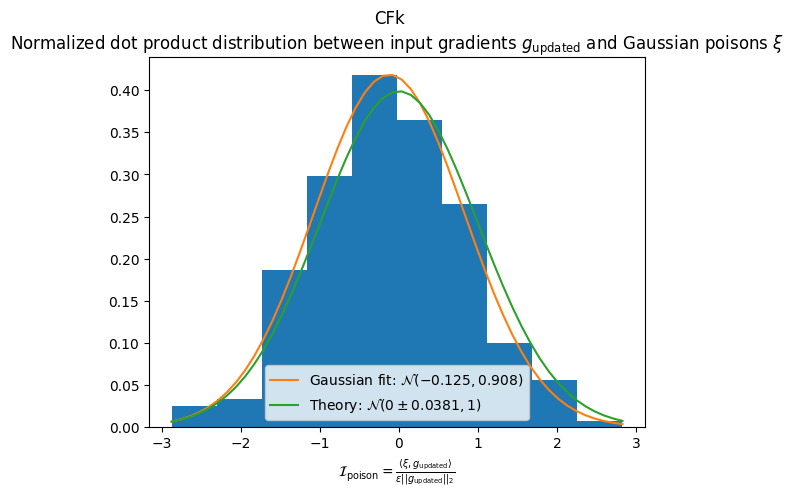

In [29]:
unlearn_epochs = epochs // 2
k = 3
unlearner = deepcopy(corrupted_model)
with unlearning_last_layers(unlearner, k, mode='cfk'):
    opt_cfk = make_optimizer(unlearner, lr=1e-3)
    train_loop(unlearner, clean_loader, loss_func, opt_cfk, epochs=unlearn_epochs)
display_post_unlearning_results(unlearner, algo_name='CFk')

### EUk

100%|█████████▉| 44300/44312 [00:00<?, ?it/s]

100%|█████████▉| 44300/44312 [00:00<?, ?it/s]

100%|█████████▉| 44300/44312 [00:00<?, ?it/s]

100%|█████████▉| 44300/44312 [00:00<?, ?it/s]

100%|█████████▉| 44300/44312 [00:00<?, ?it/s]

100%|█████████▉| 44300/44312 [00:00<?, ?it/s]

100%|█████████▉| 44300/44312 [00:00<?, ?it/s]

100%|█████████▉| 44300/44312 [00:00<?, ?it/s]



Test on clean samples:
100%|██████████| 10000/10000 [00:00<?, ?it/s]
MulticlassAccuracy: 0.716


Test on poisoned samples:
 94%|█████████▍| 650/688 [00:00<?, ?it/s]
MulticlassAccuracy: 0.693





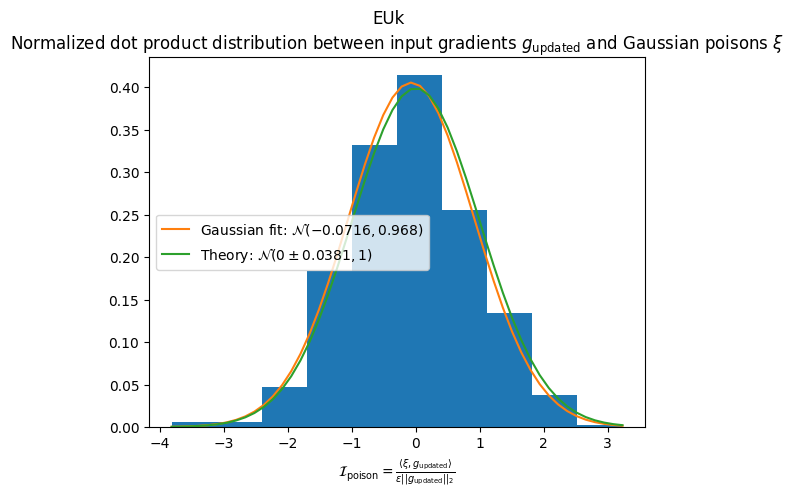

In [30]:
unlearn_epochs = epochs
k = 3
unlearner = deepcopy(corrupted_model)
with unlearning_last_layers(unlearner, k, mode='euk'):
    opt_euk = make_optimizer(unlearner, lr=1e-3)
    train_loop(unlearner, clean_loader, loss_func, opt_euk, epochs=unlearn_epochs)
display_post_unlearning_results(unlearner, algo_name='EUk')

### SCRUB

/home/lvt/.local/share/virtualenvs/ml-TQx6uCZG/lib/python3.13/site-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


100%|█████████▉| 44300/44312 [00:00<?, ?it/s]


Test on clean samples:
100%|██████████| 10000/10000 [00:00<?, ?it/s]
MulticlassAccuracy: 0.716


Test on poisoned samples:
 94%|█████████▍| 650/688 [00:00<?, ?it/s]
MulticlassAccuracy: 0.693





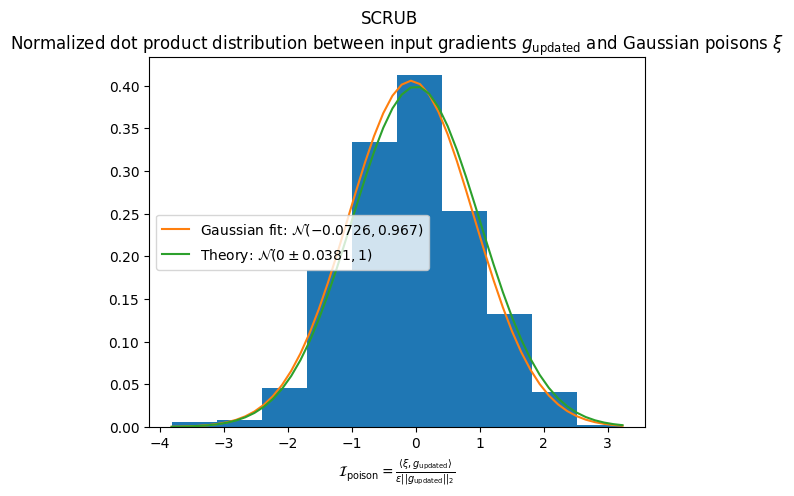

In [31]:
unlearn_epochs = epochs
teacher = deepcopy(corrupted_model)
student = deepcopy(teacher)
opt_scrub = make_optimizer(unlearner, lr=1e-6)
# FIXME: lr is the same between unlearning and learning
scrub(
    teacher, student,
    clean_loader, poisoned_loader,
    loss_func, opt_scrub,
    max_steps=1, steps=unlearn_epochs,
    alpha=0.999, gamma=0.99,
)
display_post_unlearning_results(unlearner, algo_name='SCRUB')

SCRUB does not preserve the model accuracy since the unlearning / learning batch updates are not interleaved.

## Ablation studies

For perfect unlearning, we have $GUS := \hat{\mu}_{\mathrm{updated}} = \frac{1}{P} \sum_{z \in S_{\mathrm{poison}}} I_z \sim \mathcal{N}(0, 1 / P)$ where $P = |S_{\mathrm{poison}}|$.

We define the **normalized GUS** as $normGUS := \sqrt{P} \times GUS \sim \mathcal{N}(0, 1)$.
Note that with imperfect unlearning, $normGUS < 0$.

Since this unlearning metric is more interpretable, we use it for our next ablation studies.

In [32]:
def normalized_gus(
        model: nn.Module,
        base_data: Dataset,
        noise: Dataset,
        noise_std: float,
        loss_fn: _Loss,
    ) -> float:
    I_poison = gaussian_unlearning_score(
        model,
        base_data,
        noise,
        noise_std,
        loss_fn,
    )
    mean = I_poison.mean().item()
    return np.sqrt(float(len(noise))) * mean


### Noise amplitude vs. GUS

We show that poisons with high amplitude are hard to unlearn. This highlights the need for out-of-distribution data filtering.

### Model dimension vs. GUS

We argue that larger models memorize more, thus unlearning is harder for them.

We test our hypothesis on ResNet18, ResNet34, ResNet50, ResNet101 and ResNet152.

In [ ]:
def poison_models(models: dict[nn.Module]) -> dict[nn.Module]:
    trained_on_poison = {}
    for model_name, model in models.items():
        # TODO: adjust hyperparameters according to model?
        poisoned_model = model.to(BEST_DEVICE)
        opt = make_optimizer(poisoned_model, lr=lr)
        train_val_loop(
            poisoned_model, corrupted_loader, val_loader, loss_func, opt,
            epochs=epochs, keep_pbars=False,
        )
        test_epoch(poisoned_model, test_loader, loss_func, keep_pbars=False, metric=metric)
        trained_on_poison[model_name] = poisoned_model
    return trained_on_poison

def gus_on_models(models: dict[nn.Module], unlearning_algo):
    rows = []
    for model_name, poisoned_model in models.items():
        unlearner = unlearning_algo(poisoned_model)
        test_epoch(unlearner, test_loader, loss_func, keep_pbars=False, metric=metric)
        norm_gus = normalized_gus(
            unlearner,
            base_subset,
            poisoning_noise,
            noise_std,
            loss_func_no_reduction,
        )
        num_params = torchinfo.summary(unlearner).trainable_params
        rows.append([model_name, num_params, norm_gus])
    
    return pd.DataFrame(rows, columns=['model_name', 'num_params', 'normGUS'])

In [34]:
# FIXME: these vanilla CNNs are shallow and have no residual connections,
# so hyperparameters should be different
cnns = {
    'VanillaCNN-small': SmallCNN(image_size=32*32, num_image_channels=3, batchnorm=True, dropout_rate=0.1),
    'VanillaCNN-large': BigCNN(image_size=32*32, num_image_channels=3, batchnorm=True, dropout_rate=0.2),
}
squeezenets = {'SqueezeNet v1.1': SqueezeNet1_1()}
mobilenets = {
    'MobileNetv3-small': MobileNetV3(size='small'),
    'MobileNetv3-large': MobileNetV3(size='large'),
}
efficientnets = {f'EfficientNet-B{b}': EfficientNet(b=b) for b in [1, 3, 5]}
resnets = {f'ResNet-{n}': ResNet(n) for n in [18, 50, 101]}
models = cnns | squeezenets | mobilenets | efficientnets | resnets

In [35]:
poisoned_models = poison_models(cnns)









MulticlassAccuracy: 0.471








MulticlassAccuracy: 0.573


In [36]:
poisoned_models = poison_models(models)









MulticlassAccuracy: 0.553








MulticlassAccuracy: 0.589








MulticlassAccuracy: 0.1








MulticlassAccuracy: 0.528








MulticlassAccuracy: 0.667








MulticlassAccuracy: 0.317








MulticlassAccuracy: 0.0778





KeyboardInterrupt: 

In [ ]:
def neg_grad_plus_algo(corrupted_model):
    unlearn_epochs = 4
    unlearner = deepcopy(corrupted_model)
    opt_ngp = make_sgd(unlearner, lr=1e-3)
    for _ in range(unlearn_epochs):
        neg_grad_plus(unlearner, clean_loader, poisoned_loader, loss_func, opt_ngp, beta=0.995, keep_pbars=False)
    return unlearner

In [ ]:
df = gus_on_models(poisoned_models, neg_grad_plus_algo)

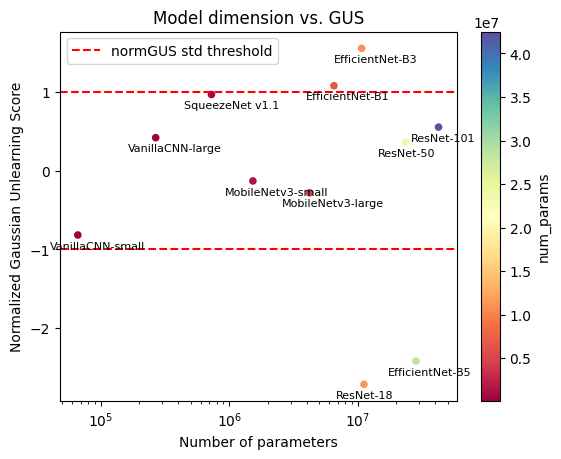

In [ ]:
from matplotlib import colormaps

ax = df.plot.scatter(
    x='num_params', y='normGUS',
    c='num_params', colormap=colormaps['Spectral'],
    logx=True,
)
plt.axhline(y=-1.0, color='r', linestyle='--', label='normGUS std threshold')
plt.axhline(y=1.0, color='r', linestyle='--')

def annotate_df(row):  
    ax.annotate(row['model_name'], [row['num_params'], row['normGUS']],
                xytext=(-20,-10), 
                textcoords='offset points',
                size=8, 
                color='black')
    
_ = df.apply(annotate_df, axis=1)
plt.xlabel('Number of parameters')
plt.ylabel('Normalized Gaussian Unlearning Score')
plt.title('Model dimension vs. GUS')
plt.legend()
plt.show()

### Training time vs. GUS

Since more epochs mean more overfitting, unlearning quality worsens with longer training.

### Unlearning time vs. GUS

We empirically show that longer unlearning is not a solution.

### Privacy / Utility tradeoff

We scatter the Accuracy vs. GUS points for different unlearning algorithms in order to illustrate the fundamental privacy / utility tradeoff.

We also plot the Accuracy vs. GUS curve by varying $\beta \in [0.9, 0.999]$ on NegGrad+ and unlearning rate on SCRUB.

### Benefits of data augmentation

These methods only work with vision datasets.

In [ ]:
class AugmentedDataset(Dataset):
    def __init__(self, dataset: Dataset):
        self._dataset = dataset
        self.transform = T.Compose([
            T.RandomCrop(size=(32, 32)),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomVerticalFlip(p=0.2),
            T.RandomRotation(20.),
            T.ColorJitter(brightness=0.5, hue=0.1),
            T.GaussianNoise(sigma=0.1),
        ])

    def __getitem__(self, index):
        X, y = self._dataset[index]
        return self.transform(X), y
    
    def __len__(self):
        return len(self._dataset)

In [ ]:
augmented_training_data = AugmentedDataset(training_data)
augmented_loader = DataLoader(augmented_training_data, batch_size=batch_size)

In [ ]:
clean_model_ = deepcopy(model)
opt = make_optimizer(clean_model_)
train_loop(clean_model_, augmented_loader, loss_func, opt, epochs=epochs)
test_epoch(clean_model_, test_loader, loss_func, keep_pbars=True, metric=metric)

## Takeaways

We successfully reproduced the results of the article of Pawelczyck et al.

**Results of our ablation studies :**

- **Larger models are more vulnerable to data poisoning** (ResNet18 vs. vanilla CNN). Indeed, when the model dimension is very high compared to the feature dimension, the model is likely to overfit on the poisons, therefore making them hard to forget. In particular, CFk and EUk work better on shallow models with few dense layers.
- **Number of epochs matter due to overfitting**.
- TODO: check with more data augmentation on top of poisoning, and more regularization.
- Data poisoning has a larger effect on high-dimensioned data. TODO: test on CIFAR-100 or ImageNette with different architectures
- **It is significantly easier to unlearn noise with smaller amplitude**. However, one might craft stealthy targeted attacks that are hard to unlearn.
- Paradoxically, the failure of unlearning is clearer with a smaller poisoning subset (since expected mean variance is inversely proportional to the number of samples)
- Techniques such as gradient ascent unlearning (GA) are more efficient at removing poisons, however the model becomes widly inaccurate on the base dataset. This highlights the tradeoff between privacy and utility. Even NegGrad+ fails to improve the GUS.
- CFk and EUk stand a better change against the GUS test, but are still far from enough since the many first layers have undergone large variations.

### Future work

- Provide a mathematical interpretation of why the unlearning gradient updates are orthogonal to the poisoned model shift: since gradients live in a large-dimensional space, [two random vectors are almost always near orthogonal](https://math.stackexchange.com/questions/995623/why-are-randomly-drawn-vectors-nearly-perpendicular-in-high-dimensions) -> very difficult to reverse the gradient descent since following the direction needs to be very precise -> need for provable machine unlearning
- Devise an "exact" unlearning method that assumes we know the exact value of the poisons. If it still fails, we may conclude that Machine Unlearning is hopeless.
- Try a MIA after Unlearning to further prove our point
- Reproduce the logistic regression model shift graph in the paper
- Perform a reconstruction GUS-based attack